# Text Classification Exam

Welcome to the Text Classification Practical Exam. In this exam, you will be tasked with building, training, and evaluating an NLP model to classify text data. You are provided with a labeled dataset containing both the text and its corresponding class labels.

Your objective is to develop a model that accurately predicts the class of the given text. Make sure to follow best practices in data preprocessing, model selection, and evaluation to achieve optimal results.

Good luck!
___

# Install and Import Needed Libraries

You can use `pyarabic` or any other library to pre-process and clean the Arabic text.

In [2]:
import re
import pandas as pd
import pyarabic.araby as araby
import nltk
from nltk.corpus import stopwords
import nltk
from nltk.stem.isri import ISRIStemmer


import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Bidirectional, SimpleRNN, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt



In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [1]:
#dawonlwding the laibers for arabic text
!pip install PyArabic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 1.2 MB/s eta 0:00:00


# Download the Dataset

Please note that you are allowed to take a subset of this dataset, the reason for that is it might take a long time to train the model on.

In [4]:
!kaggle datasets download -d khaledzsa/sanad
!unzip sanad.zip

Dataset URL: https://www.kaggle.com/datasets/khaledzsa/sanad
License(s): unknown
 91% 65.0M/71.4M [00:00<00:00, 130MB/s]
100% 71.4M/71.4M [00:00<00:00, 123MB/s]
Archive:  sanad.zip
  inflating: sanad.csv               


In [6]:
#here i will call the dataset

df=pd.read_csv("/content/sanad.csv")

#here i will give he data lethgth
max_length = 150
min_length = 15

#here i will start split the data and give it the max lethg for the words and the min lenthg
df = df[df['text'].str.split().str.len().between(min_length, max_length)]

df.head()

,text,label
4,https://example.com/resource/قُرر اَتحِاد اًلْ...,Culture
7,https://example.com/resource/توفٌي َأمس ِاَلُأ...,Culture
15,https://example.com/resource/اَلّشْاِرقِةّ:ً م...,Culture
20,https://example.com/resource/صدًرّ َعَن دارً َ...,Culture
37,https://example.com/resource/أصٌدًر ٍمشًرَوعِ ...,Culture


# Data Exploration

Before diving into preprocessing and model building, it’s important to first explore the dataset to understand its structure, distribution, and key characteristics. This step will help you gain insights into the data and guide your decisions in subsequent steps. Here’s what to consider:

1. **Inspect the Data**:
   Start by looking at the first few rows of the dataset to get a sense of its structure. Check the columns, data types, and a few sample entries. This helps to ensure that the data is loaded correctly and gives you an initial overview of the content.

2. **Check for Missing Values**:
   Identify if there are any missing values in the dataset.

3. **Distribution of Labels**:
   Examine the distribution of the target labels (classes).

4. **Text Data Characteristics (Bonus)**:
   Analyze the length of the text data. It is useful to calculate the number of words or characters in each text sample to understand how long the texts are. This will help you set a suitable `max_length` for tokenization and padding later. You can plot a histogram of text lengths to visualize the distribution.

5. **Common Words and Vocabulary (Bonus)**:
   Explore the most frequent words in the text data.

In [7]:
#here i will check if data contin null vlaues
df.isnull().sum()

text     0
label    0
dtype: int64

In [8]:
#here i will print 5 row from the head
df.head()

,text,label
4,https://example.com/resource/قُرر اَتحِاد اًلْ...,Culture
7,https://example.com/resource/توفٌي َأمس ِاَلُأ...,Culture
15,https://example.com/resource/اَلّشْاِرقِةّ:ً م...,Culture
20,https://example.com/resource/صدًرّ َعَن دارً َ...,Culture
37,https://example.com/resource/أصٌدًر ٍمشًرَوعِ ...,Culture


# Data Cleaning and Preprocessing

In this section, we will focus on cleaning and filtering the dataset, preparing it for the text classification task. We will implement the following steps:

1. **Remove missing values**:
   First, we eliminate any rows with missing values to ensure the dataset is complete and consistent.

2. **Filter by text length (Bonus)**:
   To maintain a uniform dataset, we will filter the text samples by a specified word count range. This ensures that the texts are neither too short to lack context nor too long to introduce unnecessary complexity.

3. **Arabic stopwords loading**:
   We load a list of Arabic stopwords to filter out commonly used but contextually insignificant words. This is an important step for improving the performance of the model, as stopwords do not contribute valuable information.

4. **Text cleaning**:
   We apply a series of text cleaning steps to standardize and simplify the text data. This involves:
   - **Removing links (URLs)**: Any URLs present in the text are removed as they are not meaningful for classification purposes.
   - **Removing special characters and punctuation**: This step removes any non-alphabetical characters, ensuring the text only contains meaningful words.
   - **Removing Arabic diacritics (Tashkeel) and elongated letters (Tatweel)**: Diacritical marks and elongated letters are stripped out to standardize the text.
   - **Removing Arabic stopwords**: Words that are part of the stopwords list are removed, as they do not add value to the classification task.
   - **Stemming or Lemmmatization**: Either stemming or lemmatization is applied to reduce words to their root or base form.
   - **Normalizing Hamza**: Any variation of the Hamza character is normalized for consistency.

   **Note:** Most of these you can do using the library [PyArabic](https://pyarabic.readthedocs.io/ar/latest/README.html#features)

5. **Final cleanup**:
   Apply the cleanup function to the feature column.

By following these steps, the text will be cleaned, filtered, and ready for tokenization!

In [9]:
#after cheking for the missing value the data dosen't containe any missing vlaues so i will start clean the text
#here i will start clean the text and befor going to tokins, first i will use regex to take the URL from the text

#here i will use stopwords for arabic words
arabic_stopwords = set(stopwords.words('arabic'))

#here i create function clean_text to clean my data set text
def clean_text(text):
  #here i used regex to remove the URL
  clean_text = re.sub(r'http\S+|www\S+|https\S+', '',text, flags=re.MULTILINE)
  clean_text = re.sub(r'[^\w\s]', '', clean_text)
  #here i remove the tashkeel and tatweel
  clean_text = araby.strip_tashkeel(clean_text)
  clean_text = araby.strip_tatweel(clean_text)
  #here i joined the words after cleaning
  words = clean_text.split()

#here i filterd the data and see the word it's not arabic or arabic as checking
  filtered_words = [word for word in words if word not in arabic_stopwords]

  return clean_text


In [10]:
#here i applyed the clean text on the data set (df)
df['clean_text'] = df['text'].apply(clean_text)

In [11]:
#here i print the data afte cleaning to check if got cleand or not
df['clean_text']


4         اتحاد الأدباء والكتاب الموريتانيين عقد مؤتمره...
7         أمس الأديب الإسباني ميجيل ديليبس الذي يعتبر و...
15        ميرفت الخطيب تلبية لدعوة حرم صاحب السمو الشيخ...
20        عن دار الكتب الوطنية في هيئة أبوظبي للثقافة و...
37        مشروع كلمة للترجمة في دائرة الثقافة والسياحة ...
                               ...                        
39857     مينا تليكوم البحرين عن طرح جهاز واي ماكس جديد...
39859     الخليج يسجل برنامج محمد بن راشد للتعلم الذكي ...
39866     اختارت مايكروسوفت مدينة دبي لاطلاق كل من نظام...
39872     موقع تيجوري مركز التسوق الإلكتروني الأكبر في ...
39880     شركة باناسونيك عن اطلاق سلسلة تلفزيونات فييرا...
Name: clean_text, Length: 12177, dtype: object

# Tokenization, Padding, and Data Splitting

In this step, we will prepare the text data for input into a model by converting the text into numerical sequences, padding them to a uniform length, and splitting the dataset into training and testing sets. Here's an overview of the steps involved:

1. **Tokenization**:
   We use a tokenizer to convert the cleaned text into numerical sequences. You can use `Tokenizer` tokenizer from `tensorflow.keras.preprocessing.text` package or any other tokenizer you like.

2. **Text to sequences**:
   After fitting the tokenizer on the cleaned text, we transform each text into a sequence of numbers, where each number corresponds to a token (word) in the text.

3. **Padding the sequences**:
   Since different texts may vary in length, we pad the sequences to ensure they all have the same length.

4. **Label encoding**:
   The labels (target values) also need to be converted into numerical form if they are not encoded.

5. **Train-test split**:
   The dataset is divided into training and testing sets. We allocate 80% of the data for training the model and reserve 20% for testing its performance.
   
   - The **training data** consists of the padded sequences used to train the model.
   - The **training labels** are the encoded labels corresponding to the training data.
   - The **testing data** is used to assess the model’s performance after training.
   - The **testing labels** are the encoded labels corresponding to the testing data.

6. **Data shape confirmation**:
   After splitting the data, we print the shape (dimensions) of both the training and testing sets to confirm that the data is properly divided and formatted.

By the end of this step, the text data will be transformed into padded numerical sequences, the labels will be encoded, and the data will be split into training and testing sets for model development and evaluation.

In [12]:
#here i will start using tokins befor start bulding the model so i can transfor the text into number of sequince and applyit to the model
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])
sequences = tokenizer.texts_to_sequences(df['clean_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

#here i used label encoding to encode the labels befor applyit to the model
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df['label'])

#here i split the data and teest size will be 20% and traine size 80%
train_data, test_data, train_labels, test_labels = train_test_split(
    padded_sequences,
    encoded_labels,
    test_size=0.2,
    random_state=42
)

#here i will print the shape of the data set after cleaning and split it
print("Shape of train_data:", train_data.shape)
print("Shape of train_labels:", train_labels.shape)
print("Shape of test_data:", test_data.shape)
print("Shape of test_labels:", test_labels.shape)

Shape of train_data: (9741, 150)
Shape of train_labels: (9741,)
Shape of test_data: (2436, 150)
Shape of test_labels: (2436,)


# Building the Classifier

In this step, you will design and build a NLP Classifier model to classify text data. Below is a breakdown of the key components you'll implement, but it's up to you to decide how to configure them based on your understanding and experimentation:

1. **Model Type**:
   You will use a Sequential model, which allows you to stack layers in a linear sequence.

2. **Input Layer**:
   Define the shape of the input data. Consider the dimensions of your padded sequences and set the input shape accordingly.

3. **Embedding Layer**:
   The embedding layer will convert input tokens (integers) into dense vector representations. You will need to determine the size of the input dimension (based on your vocabulary) and the output dimension (embedding size).

4. **Bidirectional Simple RNN/LSTM Layers**:
   You can add one or more recurrent layers. Consider using Bidirectional layers to capture contextual information from both directions (forward and backward). You can chose SimpleRNN/GRU/LSTM to perform this step.

5. **Dense Layers**:
   Add one or more fully connected (Dense) layers to process the output from the RNN/GRU/LSTM layers.

6. **Output Layer**:
   The output layer should match the type of classification task you're working on. Consider using appropriate activation function with appropriate number of units.

7. **Model Summary**:
   After defining your model architecture, print a summary to review the number of layers, types of layers, and total parameters.

8. **Model Compilation**:
   Finally, compile the model by selecting an optimizer, a loss function, and metrics.

In [20]:
#here i will call the model
model = Sequential([
   #here i will give the model the onput and tshape is the max lenth i create befor
    Input(shape=(max_length,)),
   #here i will add the heddin layer
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length),
    Bidirectional(SimpleRNN(64, return_sequences=True)),
    Bidirectional(SimpleRNN(32)),
    Dense(64, activation='relu'),
   #here the out put layer
    Dense(1, activation='sigmoid')
])


#i will print summry for the model
model.summary()
#here i will coplie the model and give it catogrecal catogrecal_crossentropy
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 150, 128)          13116032  
                                                                 
 bidirectional_5 (Bidirecti  (None, 150, 128)          24704     
 onal)                                                           
                                                                 
 bidirectional_6 (Bidirecti  (None, 64)                10304     
 onal)                                                           
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 13155265 (50.18 MB)
Trainable params: 13

# Defining Batch Size, Creating Datasets, and Training the Model

In this step, you will define the batch size, create TensorFlow Datasets for both training and testing, and train the model. The key elements to consider are outlined below, and it is up to you to choose the specific configurations based on your preferences and experimentation:

1. **Batch Size**:
   Select a batch size for training and testing. The batch size determines how many samples will be processed together in one forward and backward pass during training.

2. **Creating Datasets**:
   Use TensorFlow’s `Dataset.from_tensor_slices()` to create datasets from the training and testing data.

3. **Batching the Datasets**:
   Batch the datasets by grouping the data into batches of the specified size.

4. **Training the Model**:
   Train the model by fitting it on the training dataset for a specified number of epochs. You will also need to provide the validation data to monitor the model’s performance on unseen data during training.

5. **Tracking Training History**:
   During training, the model’s performance metrics (such as loss and accuracy) will be tracked over the epochs, and the results will be stored in the `history` object.

In [21]:
#here i will give the split data a batch size
batch_size = 50
#here i will fit the traine into model
train_dataset = tensorflow.data.Dataset.from_tensor_slices((train_data, train_labels))
#here i will fit the test into model
test_dataset = tensorflow.data.Dataset.from_tensor_slices((test_data, test_labels))
#here i set the batch size for traine and test
train_dataset = train_dataset.batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

In [22]:
#here i will fit the model
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
195/195 [==============================] - 61s 292ms/step - loss: 0.0000e+00 - accuracy: 0.1384 - val_loss: 0.0000e+00 - val_accuracy: 0.1478
Epoch 2/10
195/195 [==============================] - 58s 298ms/step - loss: 0.0000e+00 - accuracy: 0.1447 - val_loss: 0.0000e+00 - val_accuracy: 0.1535
Epoch 3/10
195/195 [==============================] - 58s 296ms/step - loss: 0.0000e+00 - accuracy: 0.1561 - val_loss: 0.0000e+00 - val_accuracy: 0.1613
Epoch 4/10
195/195 [==============================] - 56s 289ms/step - loss: 0.0000e+00 - accuracy: 0.1691 - val_loss: 0.0000e+00 - val_accuracy: 0.1769
Epoch 5/10
195/195 [==============================] - 62s 318ms/step - loss: 0.0000e+00 - accuracy: 0.1783 - val_loss: 0.0000e+00 - val_accuracy: 0.1753
Epoch 6/10
195/195 [==============================] - 57s 293ms/step - loss: 0.0000e+00 - accuracy: 0.1786 - val_loss: 0.0000e+00 - val_accuracy: 0.1745
Epoch 7/10
195/195 [==============================] - 57s 295ms/step - loss: 0.000

# Model Evaluation

Once the model is trained, the next step is to evaluate its performance on the testing dataset.

1. **Evaluate the Model**:
   You will use the `evaluate()` method to assess the model’s performance on the test dataset.

2. **Testing Dataset**:
   Ensure that the testing dataset is properly prepared and batched, just like the training dataset.

4. **Loss Curve**:
   A loss curve plots the loss values for both the training and validation datasets over the epochs.

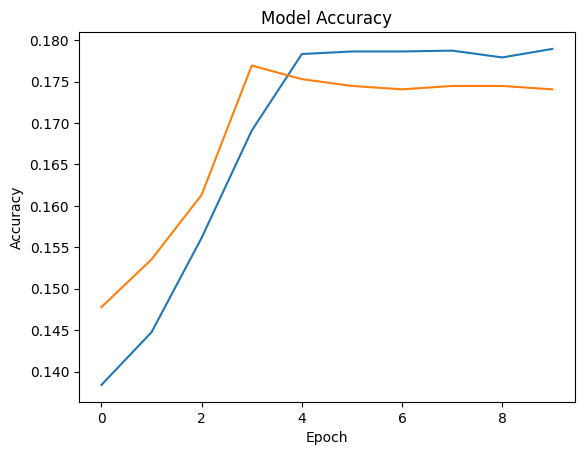

In [23]:
#here i print acuurcy evalution for the accurecy becuse it's what am foucing on in my model more than the loss
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()



# Model Inference

In this step, you will use the trained model to make predictions on new, unseen data (inference). Here’s an outline of the key points:

1. **Create Test Sample**:
   Create a string to test your modelm the goal here is to give the model Before making predictions, ensure that the new data is preprocessed in the same way as the training data. This includes tokenization, padding, and any other transformations you applied during the data preprocessing step. The data can be single text to see the result of the prediction.

2. **Model Prediction**:
   Use the `predict()` method to feed new samples into the trained model and obtain predictions. The model will output probabilities or predicted class labels based on the type of classification task (binary or multi-class).

3. **Interpreting Predictions**:
   The model will return probabilities for each class.

In [24]:
#here i want to test the model if it can predict will
sample_text = ["السلام عليكم اسمي جود"]

sample_sequence = tokenizer.texts_to_sequences([clean_text(sample_text[0])])
padded_sample_sequence = pad_sequences(sample_sequence, maxlen=max_length, padding='post')
predicted_label = model.predict(padded_sample_sequence)

#here i will print the predict label for the text
print("Predicted label:", label_encoder.inverse_transform([predicted_label.argmax()]))

1/1 [==============================] - 0s 384ms/step
Predicted label: ['Culture']


# Notebook Question:
- How did you handle text preprocessing? Why did you choose this approach?

i handel the text by using clean_text function and i removed the URL and what need to be removed by using regex it's usfule to clean any cined of text.

- Why did you choose this model design?

becues it's preformed will with text data with any kind of langue.

- Why did you pick this number of layers or units for the model?

the data size and shape is big so i want the model contin more layers so it can preformed much better , even thoe my acurccy not very higth but still prefoming fine.

- Why did you select these evaluation methods?

the accurcy from my point it will show how much the the model learn so if i want to test the model by give it a text and predict it ronge or right i will know it from the accurcy and my accurcy here 17% not very good .

- Does your model show signs of overfitting or underfitting? How do you know?

actuly i didn't use any resampling for over fitting or under fitting but from the acurrcy and lose my model under fitting.

- What changes could you make to improve the model and fix overfitting or underfitting?

 i will use reasmpling for the data to avoid the over fitting and under fitting i might add more layers and to make the model leran more if i had a big data set like text and also i will add more ephoce.

Answer Here: